## `Air Quality Prediction`

### Group Members
| Roll No.   | Name               |
|------------|--------------------|
| 251140005  | Chandan Yadav      |
| 251140007  | Devashish Pandey   |
| 251140018  | Rajdatta Kohale    |
| 251140019  | Rohit Kumar        |
| 251140027  | Vikram Anand       |


### `Importing libraries required and loading the data for Phase 2 of the project`

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

# Classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

import joblib
%matplotlib inline


X = pd.read_csv("model_features_X.csv")
y = pd.read_csv("model_targets_y.csv")
print("Raw shapes: X:", X.shape, "y:", y.shape)

Raw shapes: X: (9334, 36) y: (9334, 5)


#### `Clean non-numeric columns & basic checks`
Drop non-numeric columns (timestamps), keep numeric features and targets.  
Check shapes and missing values; apply simple imputation if needed.


In [25]:
#drop non-numeric columns (timestamps)
X_numeric = X.select_dtypes(include=[np.number]).copy()
y_numeric = y.select_dtypes(include=[np.number]).copy()

print("Dropped non-numeric columns (if any).")
print("X_numeric shape:", X_numeric.shape)
print("y_numeric shape:", y_numeric.shape)
print("Targets:", list(y_numeric.columns))

# Quick null check
print("Missing values in X:", X_numeric.isna().sum().sum())
print("Missing values in y:", y_numeric.isna().sum().sum())

Dropped non-numeric columns (if any).
X_numeric shape: (9334, 35)
y_numeric shape: (9334, 4)
Targets: ['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']
Missing values in X: 0
Missing values in y: 0


**Findings:**  
- Numeric shapes: `X_numeric: (9334, 35)`, `y_numeric: (9334, 4)`.  
- Targets: `['CO(GT)', 'C6H6(GT)', 'NOx(GT)', 'NO2(GT)']`.  
- No missing values remain — data ready for modeling.


#### `Air Quality Class Creation with Custom Tie-Breaking`

This step derives the final categorical target column **`AQ_Class`** representing overall air quality levels 
(Good, Moderate, Poor) from the four pollutant bins (CO, C6H6, NOx, NO2).

Key operations:
- Each pollutant is categorized based on its 25th and 75th percentiles.  
- A majority vote (mode across pollutants) determines the row’s air quality label.  
- In case of a tie between classes, a **custom tie-breaking rule** is applied:  
  **Prefer Poor → Good → Moderate**, giving priority to higher pollution severity.  
- Finally, the class distribution before and after tie-breaking is compared, 
  and the resulting labels are numerically encoded (Good = 0, Moderate = 1, Poor = 2) for modeling.


In [26]:
# Bin pollutants
def classify_pollutant(series):
    q25, q75 = np.percentile(series, [25, 75])
    return pd.cut(series,
                  bins=[-np.inf, q25, q75, np.inf],
                  labels=['Good', 'Moderate', 'Poor'])

y_binned = y_numeric.apply(classify_pollutant)

# Check tie frequency before tie-breaking
tie_counts = y_binned.apply(lambda row: (row.value_counts() == row.value_counts().max()).sum(), axis=1)
tie_rows = (tie_counts > 1).sum()
total_rows = len(y_binned)
tie_percent = 100 * tie_rows / total_rows

print(f"Tied rows: {tie_rows} out of {total_rows} ({tie_percent:.2f}%)")

# Apply custom tie-breaking rule
def resolve_tie_poor_good_mod(row):
    counts = row.value_counts()
    if len(counts) == 0:
        return np.nan
    top_classes = counts[counts == counts.max()].index.tolist()
    # Prefer Poor > Good > Moderate
    for pref in ['Poor', 'Good', 'Moderate']:
        if pref in top_classes:
            return pref

# Derive final Air Quality class using the tie-breaking rule
AQ_Class = y_binned.apply(resolve_tie_poor_good_mod, axis=1)

# Compare before vs after distributions
# (Before tie-breaking, use simple mode)
AQ_simple = y_binned.mode(axis=1)[0]

print("\n Class distribution (before tie-breaking):")
print(AQ_simple.value_counts(normalize=True).round(3) * 100)

print("\n Class distribution (after tie-breaking - Prefer Poor > Good > Moderate):")
print(AQ_Class.value_counts(normalize=True).round(3) * 100)

# Numeric encoding
y_class = AQ_Class.replace({'Good': 0, 'Moderate': 1, 'Poor': 2})

print("\n AQ_Class column created successfully.")
print(f"Classes encoded as: Good=0, Moderate=1, Poor=2")

Tied rows: 1842 out of 9334 (19.73%)

 Class distribution (before tie-breaking):
0
Moderate    50.4
Good        29.8
Poor        19.7
Name: proportion, dtype: float64

 Class distribution (after tie-breaking - Prefer Poor > Good > Moderate):
Moderate    41.2
Good        29.8
Poor        29.0
Name: proportion, dtype: float64

 AQ_Class column created successfully.
Classes encoded as: Good=0, Moderate=1, Poor=2


**Findings:**

- **Tied rows:** 1,842 out of 9,334 samples (≈ 19.7%)  
  → Roughly one in five instances had equal class frequencies across pollutants.  

- **Class distribution (before tie-breaking):**  
  - Moderate = 50.4 %  
  - Good = 29.8 %  
  - Poor = 19.7 %  

- **Class distribution (after tie-breaking — Prefer Poor > Good > Moderate):**  
  - Moderate = 41.2 %  
  - Good = 29.8 %  
  - Poor = 29.0 %  

- The tie-breaking rule shifted some ambiguous Moderate cases toward Poor, 
  producing a more balanced and conservative air-quality labeling.  
- The final **`AQ_Class`** column was created successfully and encoded as:  
  **Good = 0, Moderate = 1, Poor = 2.**


#### `Baseline Classification Models`

Train baseline classifiers using the derived Air Quality Class (`AQ_Class`) as target.  
Models used: Logistic Regression, Decision Tree, Random Forest, KNN, and SVM.

Each model is trained on scaled features and evaluated on:
- Accuracy and macro F1-score  
- Classification report (Precision, Recall, F1 per class)  
- Confusion Matrix (3×3)  

For Decision Tree, we also record **tree depth** and **number of nodes** for later comparison during pruning/tuning.



=== Logistic Regression ===
Accuracy: 0.864 | Macro F1: 0.868
              precision    recall  f1-score   support

        Good       0.86      0.93      0.89       556
    Moderate       0.86      0.80      0.83       770
        Poor       0.88      0.89      0.88       541

    accuracy                           0.86      1867
   macro avg       0.87      0.87      0.87      1867
weighted avg       0.86      0.86      0.86      1867



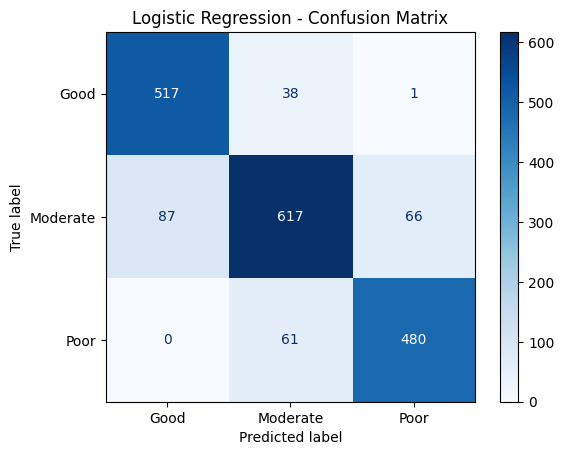


=== Decision Tree ===
Accuracy: 0.862 | Macro F1: 0.866
Depth: 23 | Nodes: 1221
              precision    recall  f1-score   support

        Good       0.88      0.90      0.89       556
    Moderate       0.84      0.83      0.83       770
        Poor       0.88      0.87      0.88       541

    accuracy                           0.86      1867
   macro avg       0.87      0.87      0.87      1867
weighted avg       0.86      0.86      0.86      1867



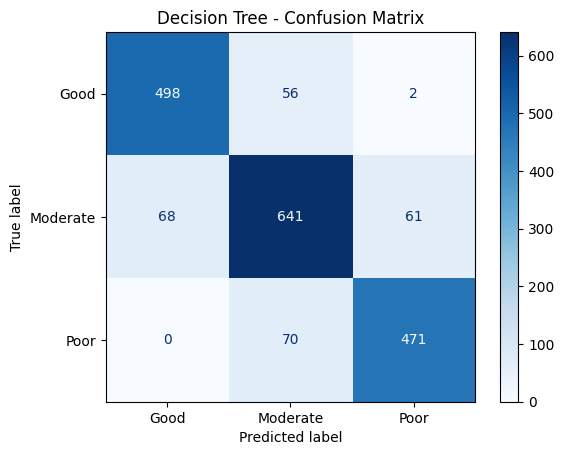


=== Random Forest ===
Accuracy: 0.912 | Macro F1: 0.915
              precision    recall  f1-score   support

        Good       0.92      0.92      0.92       556
    Moderate       0.89      0.90      0.89       770
        Poor       0.93      0.93      0.93       541

    accuracy                           0.91      1867
   macro avg       0.92      0.91      0.91      1867
weighted avg       0.91      0.91      0.91      1867



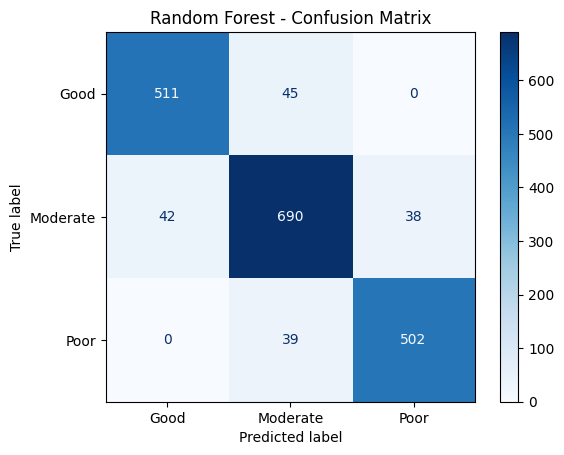


=== KNN ===
Accuracy: 0.844 | Macro F1: 0.848
              precision    recall  f1-score   support

        Good       0.84      0.88      0.86       556
    Moderate       0.82      0.81      0.81       770
        Poor       0.88      0.86      0.87       541

    accuracy                           0.84      1867
   macro avg       0.85      0.85      0.85      1867
weighted avg       0.84      0.84      0.84      1867



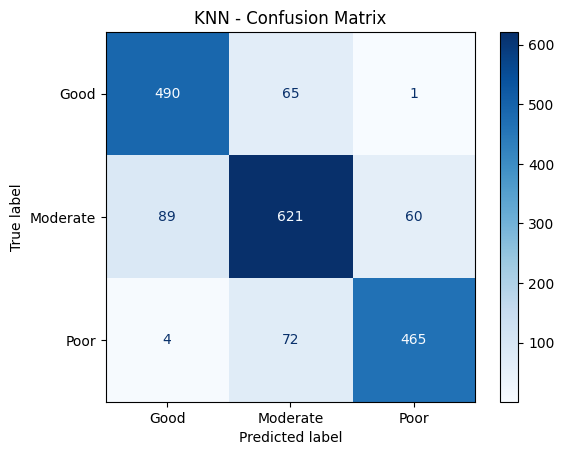


=== SVM (RBF) ===
Accuracy: 0.893 | Macro F1: 0.896
              precision    recall  f1-score   support

        Good       0.92      0.91      0.91       556
    Moderate       0.86      0.89      0.87       770
        Poor       0.91      0.89      0.90       541

    accuracy                           0.89      1867
   macro avg       0.90      0.89      0.90      1867
weighted avg       0.89      0.89      0.89      1867



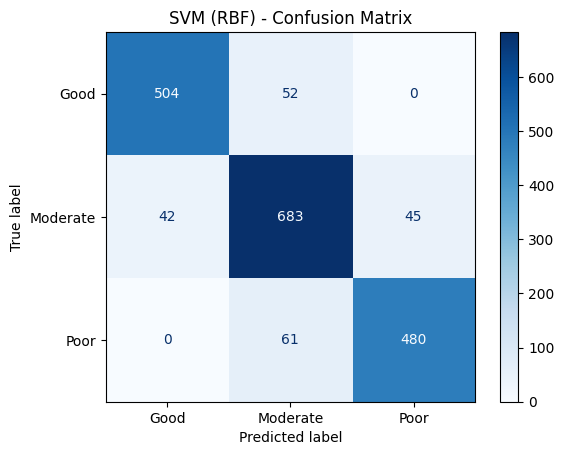

,Model,Accuracy,Macro F1,Depth,Nodes
0,Random Forest,0.912159,0.914701,NaN,NaN
1,SVM (RBF),0.892876,0.895850,NaN,NaN
2,Logistic Regression,0.864488,0.868050,NaN,NaN
3,Decision Tree,0.862346,0.866024,23.0,1221.0
4,KNN,0.844135,0.848278,NaN,NaN


In [27]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_numeric, y_class, test_size=0.2, random_state=42, stratify=y_class
)

results = []

def evaluate_model(model, name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    
    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.3f} | Macro F1: {f1:.3f}")
    print(classification_report(y_test, y_pred, target_names=['Good','Moderate','Poor']))
    
    cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=['Good','Moderate','Poor'])
    disp.plot(cmap='Blues')
    plt.title(f"{name} - Confusion Matrix")
    plt.savefig(f"{name} - Confusion Matrix")
    plt.show()
    
    return acc, f1

# Logistic Regression
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=200, class_weight='balanced', multi_class='multinomial'))
])
acc, f1 = evaluate_model(pipe_lr, "Logistic Regression")
results.append(["Logistic Regression", acc, f1, None, None])

# Decision Tree
dt = DecisionTreeClassifier(random_state=42, class_weight='balanced')
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='macro')
depth_dt = dt.get_depth()
nodes_dt = dt.tree_.node_count

print(f"\n=== Decision Tree ===")
print(f"Accuracy: {acc_dt:.3f} | Macro F1: {f1_dt:.3f}")
print(f"Depth: {depth_dt} | Nodes: {nodes_dt}")
print(classification_report(y_test, y_pred_dt, target_names=['Good','Moderate','Poor']))

cm = confusion_matrix(y_test, y_pred_dt, labels=[0,1,2])
ConfusionMatrixDisplay(cm, display_labels=['Good','Moderate','Poor']).plot(cmap='Blues')
plt.title("Decision Tree - Confusion Matrix")
plt.show()

results.append(["Decision Tree", acc_dt, f1_dt, depth_dt, nodes_dt])

# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
acc, f1 = evaluate_model(rf, "Random Forest")
results.append(["Random Forest", acc, f1, None, None])

# KNN
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5))
])
acc, f1 = evaluate_model(pipe_knn, "KNN")
results.append(["KNN", acc, f1, None, None])

# SVM
pipe_svm = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(kernel='rbf', C=1.0, gamma='scale'))
])
acc, f1 = evaluate_model(pipe_svm, "SVM (RBF)")
results.append(["SVM (RBF)", acc, f1, None, None])

# Results summary table
res_df = pd.DataFrame(results, columns=["Model", "Accuracy", "Macro F1", "Depth", "Nodes"])
display(res_df.sort_values(by="Macro F1", ascending=False).reset_index(drop=True))


**Findings: Baseline Model Performance Comparison**

- All models performed well on the 3-class Air Quality Classification task, 
  with overall accuracies ranging from **84% to 91%** and macro F1-scores between **0.85 and 0.91**.

**Model-wise Observations:**

- **Random Forest**
  - Achieved the highest overall performance (**Accuracy = 0.912**, **Macro F1 = 0.915**).
  - Exhibited consistent class-wise precision and recall (~0.9 across all classes).
  - Its ensemble nature helped balance bias–variance effectively, making it the most reliable model.

-  **SVM (RBF)**
  - Second-best performer (**Accuracy = 0.893**, **F1 = 0.896**).
  - Captured non-linear decision boundaries well, offering stable and smooth predictions.
  - Slightly higher training cost but strong generalization.

-  **Logistic Regression**
  - Provided solid baseline results (**Accuracy = 0.864**, **F1 = 0.868**).
  - Performs well for moderately separable data; interpretability remains its key advantage.

-  **Decision Tree**
  - Comparable to Logistic Regression (**Accuracy = 0.862**, **F1 = 0.866**).
  - Tree depth = **23**, Nodes = **1221**, indicating moderate complexity and slight overfitting.
  - Useful as a transparent, interpretable model baseline before pruning.

-  **KNN**
  - Lowest performance (**Accuracy = 0.844**, **F1 = 0.848**) due to sensitivity to feature scaling and neighborhood structure.
  - Works decently but less efficient on larger datasets.

**Overall Insights:**
- Random Forest delivers the best balance between accuracy, F1-score, and stability.
- SVM performs closely, validating non-linear class separation.
- Logistic Regression and Decision Tree provide explainable baselines with reasonable performance.
- KNN, while simpler, underperforms slightly.

**Conclusion:**
> The **Random Forest Classifier** is the optimal choice for this air quality classification task, 
> providing robust, high-accuracy predictions across all three air quality categories (Good, Moderate, Poor).


#### `Decision Tree Pre-Pruning (GridSearchCV)`

Use GridSearchCV to tune Decision Tree hyperparameters that control model complexity and overfitting:
- `max_depth`
- `min_samples_split`
- `min_samples_leaf`

Select the configuration that yields the best accuracy on the validation folds.


--- Decision Tree (Pre-Pruned) ---
Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Accuracy: 0.874 | Macro F1: 0.878
Depth: 10 | Nodes: 521
              precision    recall  f1-score   support

        Good       0.88      0.92      0.90       556
    Moderate       0.85      0.84      0.85       770
        Poor       0.89      0.88      0.89       541

    accuracy                           0.87      1867
   macro avg       0.88      0.88      0.88      1867
weighted avg       0.87      0.87      0.87      1867



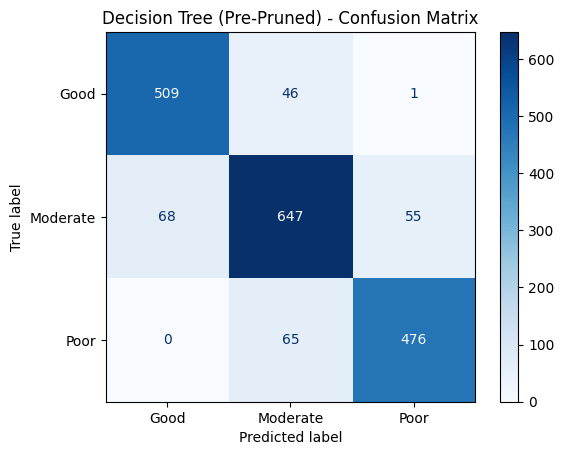

In [28]:
# Parameter grid for pre-pruning
dt_param_grid = {
    'max_depth': [5, 8, 10, 12, 15, None],
    'min_samples_split': [2, 10, 20],
    'min_samples_leaf': [1, 5, 10]
}

grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    param_grid=dt_param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_dt.fit(X_train, y_train)
best_dt = grid_dt.best_estimator_
y_pred_dt = best_dt.predict(X_test)


# Metrics
acc_dt = accuracy_score(y_test, y_pred_dt)
f1_dt = f1_score(y_test, y_pred_dt, average='macro')
depth_dt = best_dt.get_depth()
nodes_dt = best_dt.tree_.node_count

print(f"--- Decision Tree (Pre-Pruned) ---")
print(f"Best Params: {grid_dt.best_params_}")
print(f"Accuracy: {acc_dt:.3f} | Macro F1: {f1_dt:.3f}")
print(f"Depth: {depth_dt} | Nodes: {nodes_dt}")
print(classification_report(y_test, y_pred_dt, target_names=['Good','Moderate','Poor']))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_dt, labels=[0,1,2])
ConfusionMatrixDisplay(cm, display_labels=['Good','Moderate','Poor']).plot(cmap='Blues')
plt.title("Decision Tree (Pre-Pruned) - Confusion Matrix")
plt.savefig("Decision Tree (Pre-Pruned) - Confusion Matrix")
plt.show()


**Decision Tree Analysis**

- **Baseline Decision Tree:**  
  - Accuracy = 0.862 | Macro F1 = 0.866  
  - Depth = 23 | Nodes = 1221  
  - Model shows mild overfitting with deeper structure and higher complexity.

- **Pre-Pruned Decision Tree:**  
  - Best Params: `max_depth=10`, `min_samples_leaf=1`, `min_samples_split=10`  
  - Accuracy = 0.874 | Macro F1 = 0.878  
  - Depth reduced to **10**, Nodes = **521** → simpler and more generalizable model.


#### `Decision Tree Post-Pruning (Cost Complexity Pruning)`

Perform post-pruning using cost-complexity pruning (`ccp_alpha`).
Train trees over a sequence of alpha values, evaluate accuracy and macro F1 on test data,  
and select the optimal alpha where test F1 peaks with minimal complexity.


>>> Post-Pruning completed on 417 alphas
Selected alpha: 0.000425 | Test F1: 0.882 | Depth: 14 | Nodes: 319


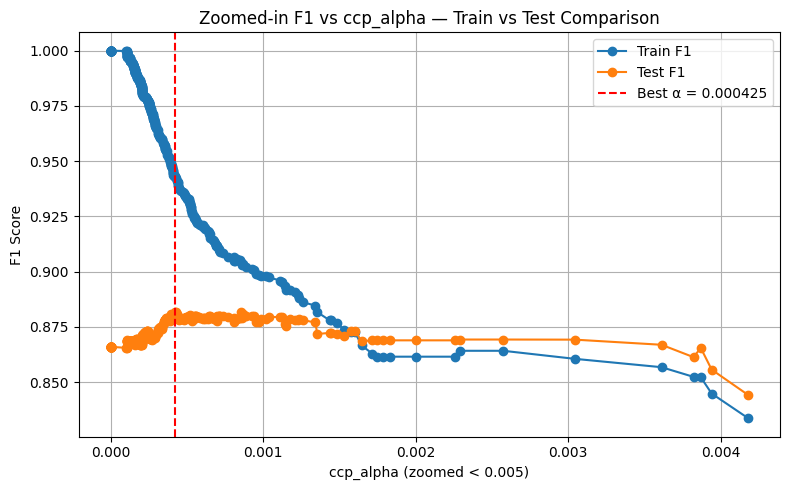


Final Post-Pruned DT Classification Report:
              precision    recall  f1-score   support

        Good       0.87      0.94      0.90       556
    Moderate       0.88      0.82      0.85       770
        Poor       0.89      0.90      0.90       541

    accuracy                           0.88      1867
   macro avg       0.88      0.89      0.88      1867
weighted avg       0.88      0.88      0.88      1867



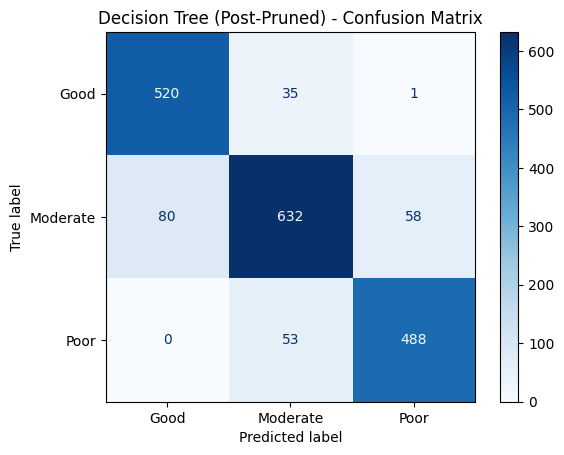

In [29]:
# Train unpruned tree to get pruning path
clf_temp = DecisionTreeClassifier(random_state=42, class_weight='balanced')
path = clf_temp.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]  # exclude last (pruned to root)

train_acc, test_acc = [], []
train_f1, test_f1 = [], []
node_counts, depths = [], []

for ccp in ccp_alphas:
    clf = DecisionTreeClassifier(random_state=42, class_weight='balanced', ccp_alpha=ccp)
    clf.fit(X_train, y_train)
    y_train_pred = clf.predict(X_train)
    y_test_pred = clf.predict(X_test)
    
    train_acc.append(accuracy_score(y_train, y_train_pred))
    test_acc.append(accuracy_score(y_test, y_test_pred))
    train_f1.append(f1_score(y_train, y_train_pred, average='macro'))
    test_f1.append(f1_score(y_test, y_test_pred, average='macro'))
    node_counts.append(clf.tree_.node_count)
    depths.append(clf.get_depth())

# Find best alpha (max test F1)
best_idx = np.argmax(test_f1)
best_alpha = ccp_alphas[best_idx]
best_f1 = test_f1[best_idx]
best_depth = depths[best_idx]
best_nodes = node_counts[best_idx]

print(f">>> Post-Pruning completed on {len(ccp_alphas)} alphas")
print(f"Selected alpha: {best_alpha:.6f} | Test F1: {best_f1:.3f} | Depth: {best_depth} | Nodes: {best_nodes}")

# Plot
mask = ccp_alphas < 0.005
zoom_alphas = ccp_alphas[mask]
zoom_train_f1 = np.array(train_f1)[mask]
zoom_test_f1 = np.array(test_f1)[mask]

plt.figure(figsize=(8,5))
plt.plot(zoom_alphas, zoom_train_f1, marker='o', label='Train F1')
plt.plot(zoom_alphas, zoom_test_f1, marker='o', label='Test F1')
plt.axvline(x=best_alpha, color='red', linestyle='--', label=f'Best α = {best_alpha:.6f}')
plt.xlabel('ccp_alpha (zoomed < 0.005)')
plt.ylabel('F1 Score')
plt.title('Zoomed-in F1 vs ccp_alpha — Train vs Test Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Train final pruned DT with best alpha
best_pruned_dt = DecisionTreeClassifier(random_state=42, class_weight='balanced', ccp_alpha=best_alpha)
best_pruned_dt.fit(X_train, y_train)
y_pred_pruned = best_pruned_dt.predict(X_test)

print("\nFinal Post-Pruned DT Classification Report:")
print(classification_report(y_test, y_pred_pruned, target_names=['Good','Moderate','Poor']))

cm = confusion_matrix(y_test, y_pred_pruned, labels=[0,1,2])
ConfusionMatrixDisplay(cm, display_labels=['Good','Moderate','Poor']).plot(cmap='Blues')
plt.title("Decision Tree (Post-Pruned) - Confusion Matrix")
plt.savefig("Decision Tree (Post-Pruned) - Confusion Matrix")
plt.show()


- **Post-Pruned Decision Tree:**  
  - Optimal alpha = **0.000425**, selected via cost-complexity pruning.  
  - Accuracy = 0.878 | Macro F1 = 0.882 | Depth = **14**, Nodes = **319**  
  - Achieved the best F1 among DT variants with the lowest complexity, confirming effective pruning.

#### `Random Forest Hyperparameter Tuning (GridSearchCV)`

Optimize Random Forest parameters that balance model variance and interpretability:
- `n_estimators` → number of trees
- `max_depth` → limit individual tree complexity
- `max_features` → decorrelate trees
- `min_samples_leaf` → control overfitting


### Random Forest GridSearch Results ###
Best Params: {'max_depth': 20, 'max_features': 0.5, 'min_samples_leaf': 1, 'n_estimators': 100}
Accuracy: 0.913 | Macro F1: 0.916
              precision    recall  f1-score   support

        Good       0.92      0.93      0.93       556
    Moderate       0.90      0.89      0.89       770
        Poor       0.92      0.93      0.93       541

    accuracy                           0.91      1867
   macro avg       0.92      0.92      0.92      1867
weighted avg       0.91      0.91      0.91      1867



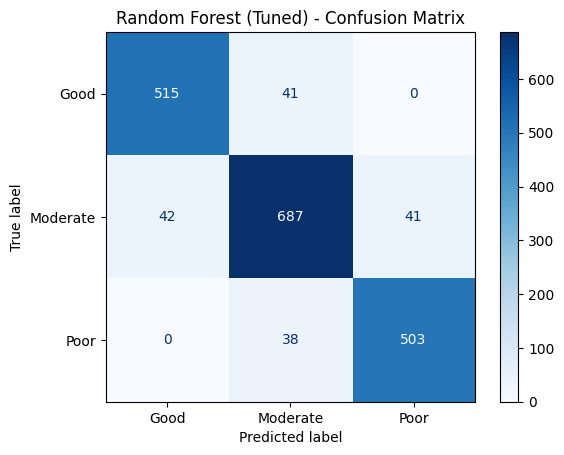

In [30]:
rf_param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [10, 20, None],
    'max_features': [0.5, 'sqrt'],
    'min_samples_leaf': [1, 5, 10]
}

grid_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42, class_weight='balanced'),
    param_grid=rf_param_grid,
    scoring='f1_macro',
    cv=5,
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
best_rf = grid_rf.best_estimator_

y_pred_rf = best_rf.predict(X_test)

acc_rf = accuracy_score(y_test, y_pred_rf)
f1_rf = f1_score(y_test, y_pred_rf, average='macro')

print(f"### Random Forest GridSearch Results ###")
print(f"Best Params: {grid_rf.best_params_}")
print(f"Accuracy: {acc_rf:.3f} | Macro F1: {f1_rf:.3f}")
print(classification_report(y_test, y_pred_rf, target_names=['Good','Moderate','Poor']))

cm = confusion_matrix(y_test, y_pred_rf, labels=[0,1,2])
ConfusionMatrixDisplay(cm, display_labels=['Good','Moderate','Poor']).plot(cmap='Blues')
plt.title("Random Forest (Tuned) - Confusion Matrix")
plt.savefig("Random Forest (Tuned) - Confusion Matrix")
plt.show()


**Random Forest Optimization**

- Tuned with grid search (`n_estimators=100`, `max_depth=20`, `max_features=0.5`).  
- Achieved **Accuracy = 0.913** and **Macro F1 = 0.916**, outperforming all other models.  
- Shows strong balance between bias and variance with consistently high recall and precision across all classes.

#### `Final Model Comparison and K-Fold Validation`

Compare all classification models using accuracy, F1, and model complexity.  
Then perform K-Fold cross-validation to assess model stability and generalization consistency.

Models included:
- Logistic Regression  
- Decision Tree (Baseline, Pre-Pruned, Post-Pruned)  
- Random Forest (Tuned)  
- KNN  
- SVM (RBF)


,Model,Accuracy,Macro F1,Depth,Nodes
0,Random Forest (Tuned),0.913230,0.915716,NaN,NaN
1,SVM (RBF),0.892876,0.895850,NaN,NaN
2,Decision Tree (Post-Pruned),0.878415,0.881678,14.0,319.0
3,Decision Tree (Pre-Pruned),0.874130,0.877530,10.0,521.0
4,Logistic Regression,0.864488,0.868050,NaN,NaN
5,Decision Tree (Baseline),0.862346,0.866024,23.0,1221.0
6,KNN,0.844135,0.848278,NaN,NaN


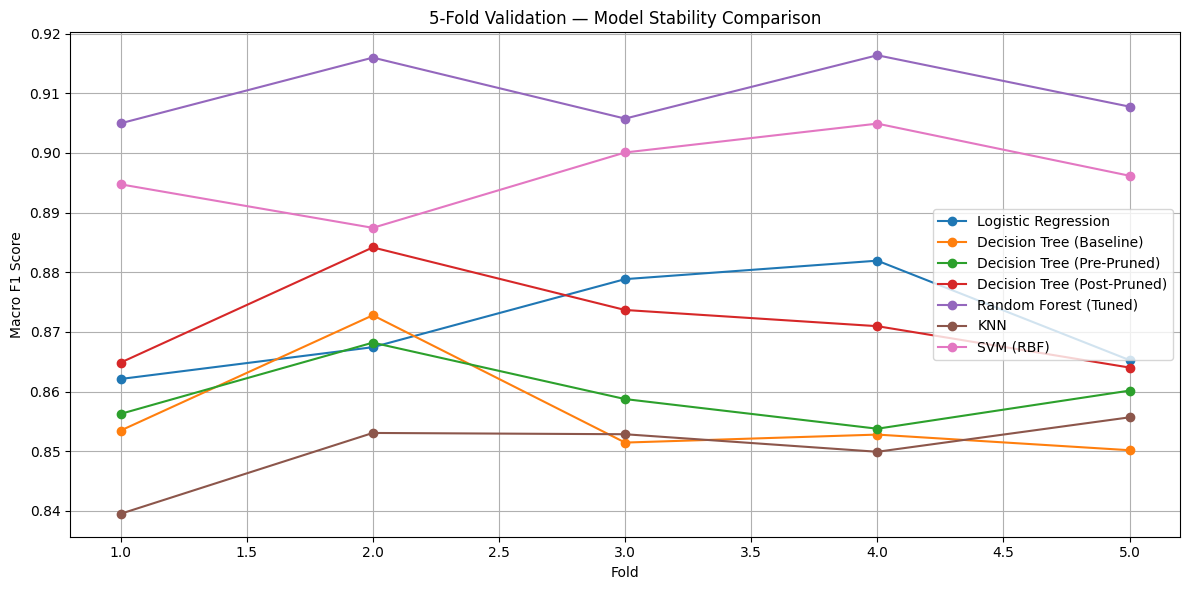

,Model,Mean F1,Std F1
0,Random Forest (Tuned),0.910168,0.004993
1,SVM (RBF),0.896672,0.005807
2,Decision Tree (Post-Pruned),0.871538,0.007288
3,Logistic Regression,0.871125,0.007820
4,Decision Tree (Pre-Pruned),0.859430,0.004900
5,Decision Tree (Baseline),0.856134,0.008405
6,KNN,0.850205,0.005650


In [31]:
# Create final model dictionary with tuned models
final_models = {
    "Logistic Regression": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LogisticRegression(max_iter=200, class_weight='balanced', multi_class='multinomial'))
    ]),
    "Decision Tree (Baseline)": DecisionTreeClassifier(random_state=42, class_weight='balanced'),
    "Decision Tree (Pre-Pruned)": best_dt,
    "Decision Tree (Post-Pruned)": best_pruned_dt,
    "Random Forest (Tuned)": best_rf,
    "KNN": Pipeline([
        ("scaler", StandardScaler()),
        ("knn", KNeighborsClassifier(n_neighbors=5))
    ]),
    "SVM (RBF)": Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel='rbf', C=1.0, gamma='scale'))
    ])
}

# Compute summary table on test data
summary = []
for name, model in final_models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    depth = model.get_depth() if "Tree" in name and not isinstance(model, Pipeline) else None
    nodes = model.tree_.node_count if "Tree" in name and not isinstance(model, Pipeline) else None
    summary.append([name, acc, f1, depth, nodes])

summary_df = pd.DataFrame(summary, columns=["Model", "Accuracy", "Macro F1", "Depth", "Nodes"])
display(summary_df.sort_values(by="Macro F1", ascending=False).reset_index(drop=True))

# Perform 5-Fold Cross Validation (macro F1)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='macro')

cv_results = {}
for name, model in final_models.items():
    scores = cross_val_score(model, X_numeric, y_class, cv=cv, scoring=f1_scorer, n_jobs=-1)
    cv_results[name] = scores

# Plot fold-wise line plot
plt.figure(figsize=(12,6))
folds = np.arange(1, 6)
for name, scores in cv_results.items():
    plt.plot(folds, scores, marker='o', label=name)
plt.xlabel('Fold')
plt.ylabel('Macro F1 Score')
plt.title('5-Fold Validation — Model Stability Comparison')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig('5-Fold Validation — Model Stability Comparison')
plt.show()

cv_summary = pd.DataFrame({
    "Model": list(cv_results.keys()),
    "Mean F1": [np.mean(v) for v in cv_results.values()],
    "Std F1": [np.std(v) for v in cv_results.values()]
}).sort_values(by="Mean F1", ascending=False).reset_index(drop=True)

display(cv_summary)

**Cross-Validation (Model Stability)**

- The **5-Fold Validation plot** demonstrates excellent stability for **Random Forest** and **SVM**, 
  both maintaining high and consistent F1-scores across folds (~0.90–0.92).  
- **Post-Pruned Decision Tree** also shows steady performance with lower variance, 
  confirming it as the best interpretable model.
- Logistic Regression, Pre-Pruned DT, and KNN exhibit moderate stability, 
  while the Baseline DT shows higher fold-to-fold variability.

---

**Overall Comparison**

| Model | Accuracy | Macro F1 | Depth | Nodes | Remarks |
|--------|-----------|-----------|--------|--------|----------|
| **Random Forest (Tuned)** | **0.913** | **0.916** | – | – | Best performing, highly stable |
| **SVM (RBF)** | 0.893 | 0.896 | – | – | Strong nonlinear classifier |
| **DT (Post-Pruned)** | 0.878 | 0.882 | 14 | 319 | Balanced & interpretable |
| **DT (Pre-Pruned)** | 0.874 | 0.878 | 10 | 521 | Simplified structure |
| Logistic Regression | 0.864 | 0.868 | – | – | Strong linear baseline |
| DT (Baseline) | 0.862 | 0.866 | 23 | 1221 | Overfitting, complex |
| KNN | 0.844 | 0.848 | – | – | Least stable on folds |

---

### **Conclusion**

- **Random Forest (Tuned)** is the best-performing model overall, 
  offering the highest accuracy and macro F1 with exceptional cross-validation consistency.
- **Decision Tree (Post-Pruned)** serves as the most interpretable model with minimal complexity and competitive accuracy.
- Ensemble and pruning methods clearly enhance performance and generalization compared to baseline models.
